In [1]:
import os
import kagglehub
import pandas as pd

import mlflow
import mlflow.sklearn
import matplotlib.pyplot as plt
import tempfile
import subprocess
import time

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

from sklearn.metrics import root_mean_squared_error, mean_absolute_error

/Users/marek/miniconda3/envs/python-for-data-analysis/lib/python3.13/site-packages/mlflow/models/__init__.py:37: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  self.utc_time_created = str(utc_time_created or datetime.utcnow())


## Execise 1

In this exercise, do the following:
1. Load the dataset used in the time series example - Energy consumption data. You can find it in the notebook "TSA_Example" in Time Series folder in Moodle.
2. Setup a nested MLFlow loop where different modelling experiments can be tracked and the use the dataset in point 1 to experiment and track models. You should do following combinations:
    1. At least 3 model types
    2. At least 3 different feature combinations
    3. At least 3 different options for 3 different hyperparameters
    4. At least 3 different time splits for train test
3. For each option in the combination, you should calculate & log the following in MLFlow:
    1. RMSE
    2. MAE
    3. Plot of actual vs predicted for 1 month data
    4. Plot of actual vs predicted for 1 week of data
    5. All of the combination info in point 2, such as which model, what feature combindation, what hyperparameter, what train test split has been used
4. Turn on MLFlow UI and track your experiments

In [2]:
path = kagglehub.dataset_download("robikscube/hourly-energy-consumption")
dataset_path = "/Users/marek/.cache/kagglehub/datasets/robikscube/hourly-energy-consumption/versions/3"
files = os.listdir(dataset_path)
file_path = "/Users/marek/.cache/kagglehub/datasets/robikscube/hourly-energy-consumption/versions/3/PJME_hourly.csv"

df = pd.read_csv(file_path)
df = df.set_index('Datetime')
df.index = pd.to_datetime(df.index)
df = df.sort_index()

def create_features(df):

    df = df.copy()

    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week

    df['lag_1d'] = df['PJME_MW'].shift(1)   
    df['lag_1w'] = df['PJME_MW'].shift(7)   
    df['lag_1m'] = df['PJME_MW'].shift(30)  
    df['lag_1y'] = df['PJME_MW'].shift(365)

    df['rolling_mean_3d'] = df['PJME_MW'].rolling(window=3).mean()
    df['rolling_mean_30d'] = df['PJME_MW'].rolling(window=30).mean()
    df['rolling_mean_same_month_last_year'] = df['PJME_MW'].shift(365).rolling(window=30).mean()
    df['rolling_mean_same_week_last_year'] = df['PJME_MW'].shift(365).rolling(window=7).mean()

    df = df.fillna(df.mean())

    return df


<Figure size 640x480 with 0 Axes>

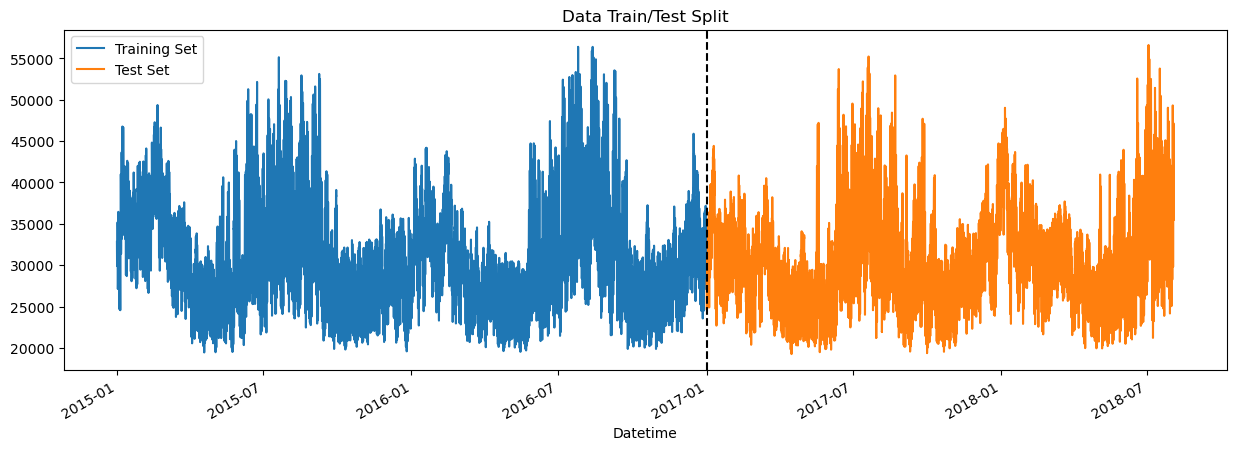

<Figure size 640x480 with 0 Axes>

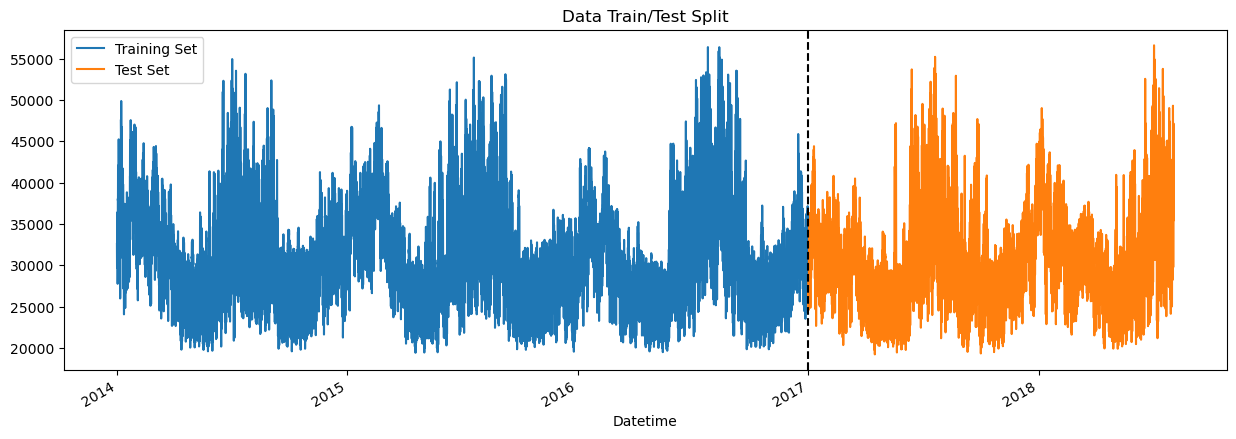

<Figure size 640x480 with 0 Axes>

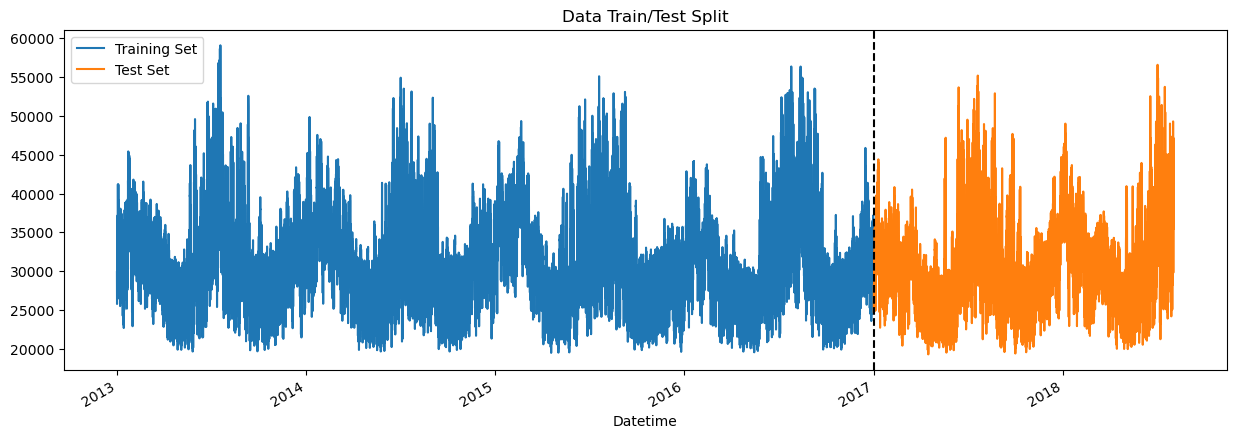

In [3]:
train_1 = df.loc[(df.index < '01-01-2017') & (df.index >= '01-01-2015')]
test_1 = df.loc[(df.index >= '01-01-2017')]

train_2 = df.loc[(df.index < '01-01-2017') & (df.index >= '01-01-2014')]
test_2 = df.loc[(df.index >= '01-01-2017')]

train_3 = df.loc[(df.index < '01-01-2017') & (df.index >= '01-01-2013')]
test_3 = df.loc[(df.index >= '01-01-2017')]

plt.clf()
fig, ax = plt.subplots(figsize=(15, 5))
train_1.plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test_1.plot(ax=ax, label='Test Set')
ax.axvline('01-01-2017', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

plt.clf()
fig, ax = plt.subplots(figsize=(15, 5))
train_2.plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test_2.plot(ax=ax, label='Test Set')
ax.axvline('01-01-2017', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

plt.clf()
fig, ax = plt.subplots(figsize=(15, 5))
train_3.plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test_3.plot(ax=ax, label='Test Set')
ax.axvline('01-01-2017', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

In [4]:
train_1 = create_features(train_1)
test_1 = create_features(test_1)

train_2 = create_features(train_2)
test_2 = create_features(test_2)

train_3 = create_features(train_3)
test_3 = create_features(test_3)

In [5]:
FEATURES_1 = [
    'hour', 'dayofweek', 'quarter', 'month', 'year', 'dayofyear', 'dayofmonth', 'weekofyear',
    ]

FEATURES_2 = [
    'hour', 'dayofweek', 'quarter', 'month', 'year', 'dayofyear', 'dayofmonth', 'weekofyear',
    'lag_1d', 'lag_1w', 'lag_1m', 'lag_1y']

FEATURES_3 = [
    'hour', 'dayofweek', 'quarter', 'month', 'year', 'dayofyear', 'dayofmonth', 'weekofyear',
    'lag_1d', 'lag_1w', 'lag_1m', 'lag_1y',
    'rolling_mean_3d', 'rolling_mean_30d', 'rolling_mean_same_month_last_year', 'rolling_mean_same_week_last_year'
]

TARGET = 'PJME_MW'

feature_combinations = [FEATURES_1, FEATURES_2, FEATURES_3]

train_test_combinations = list(zip(['train_1','train_2','train_3'], [train_1, train_2, train_3], [test_1, test_2, test_3]))

models = [
    ("LinearRegression", LinearRegression()),
    ("RandomForest", RandomForestClassifier(n_estimators=3, random_state=42, max_depth=3)),
    ("XGBoost", xgb.XGBRegressor())
]

INFO: 'MLFlow Exercise 1' does not exist. Creating a new experiment
Params Logged...
LinearRegressionfitted
6271.6690056499565
4558.252981655633
Metric Logged...


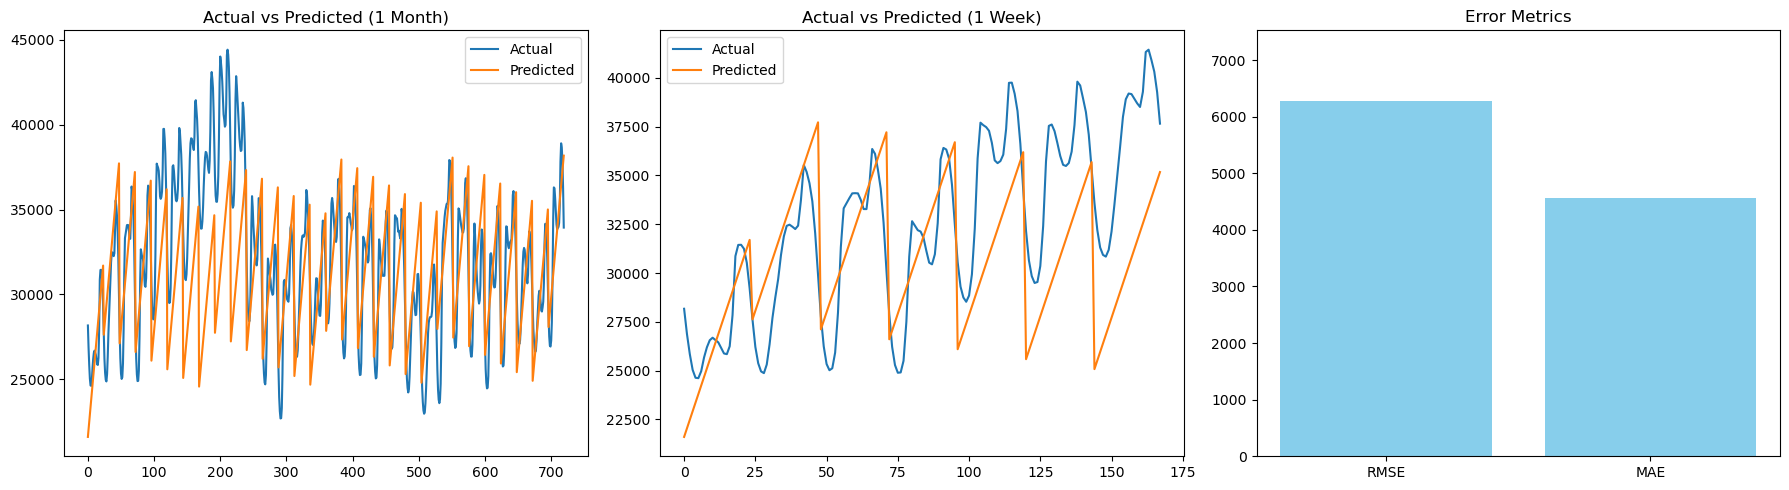

Plots Logged...
Model Logged...
Params Logged...
LinearRegressionfitted
5654.489565672974
4240.34609105627
Metric Logged...


/Users/marek/miniconda3/envs/python-for-data-analysis/lib/python3.13/site-packages/mlflow/models/__init__.py:37: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  self.utc_time_created = str(utc_time_created or datetime.utcnow())


<Figure size 640x480 with 0 Axes>

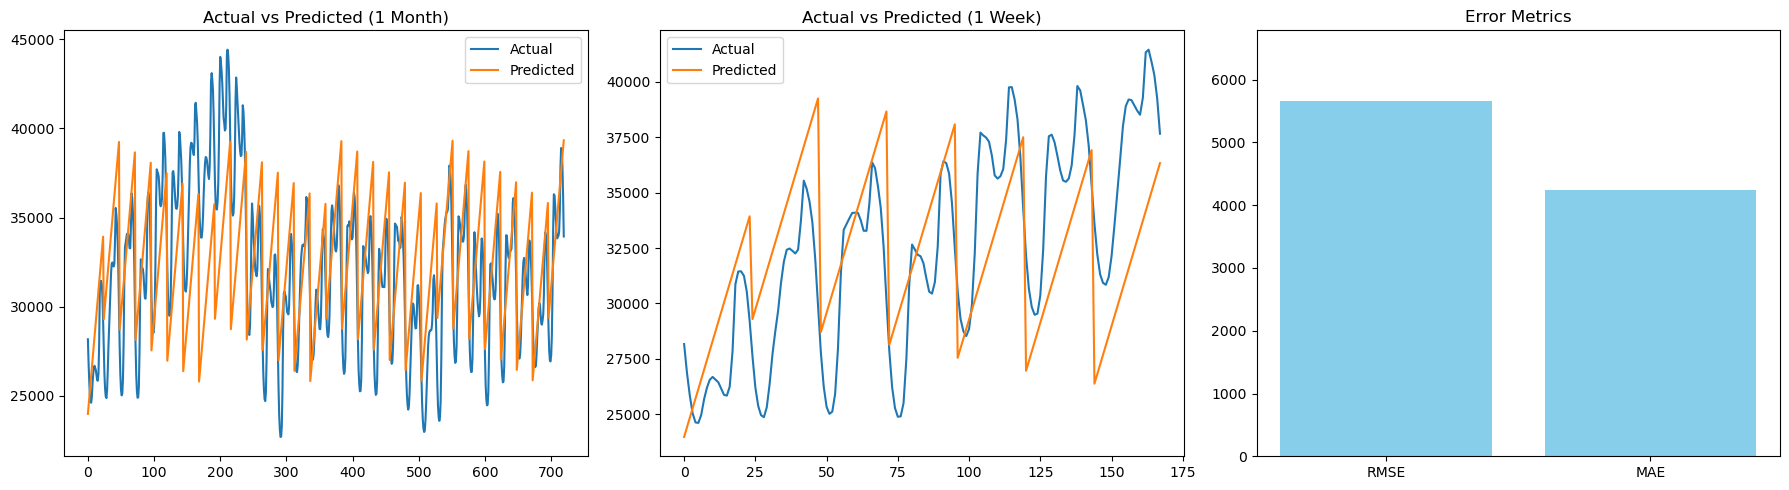

Plots Logged...
Model Logged...
Params Logged...
LinearRegressionfitted
5486.172717872961
4215.586878634039
Metric Logged...


/Users/marek/miniconda3/envs/python-for-data-analysis/lib/python3.13/site-packages/mlflow/models/__init__.py:37: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  self.utc_time_created = str(utc_time_created or datetime.utcnow())


<Figure size 640x480 with 0 Axes>

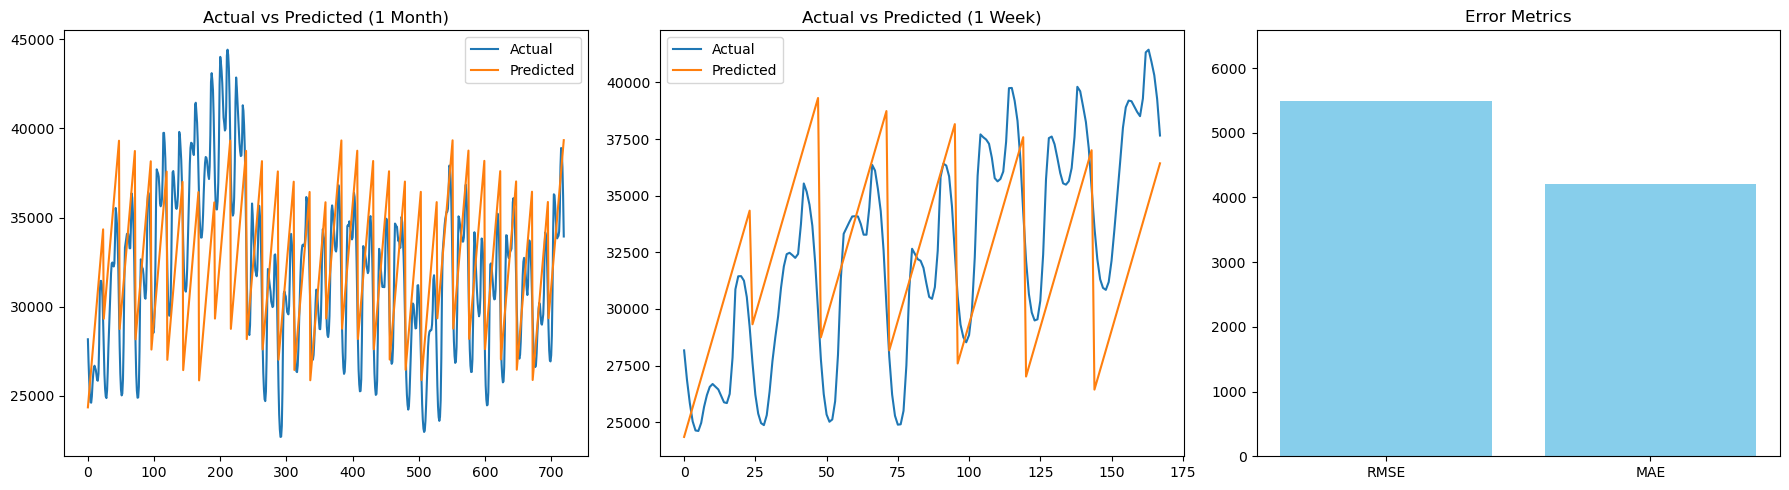

Plots Logged...
Model Logged...
Params Logged...
RandomForestfitted


/Users/marek/miniconda3/envs/python-for-data-analysis/lib/python3.13/site-packages/mlflow/models/__init__.py:37: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  self.utc_time_created = str(utc_time_created or datetime.utcnow())


6977.631913553625
5360.752158894646
Metric Logged...


<Figure size 640x480 with 0 Axes>

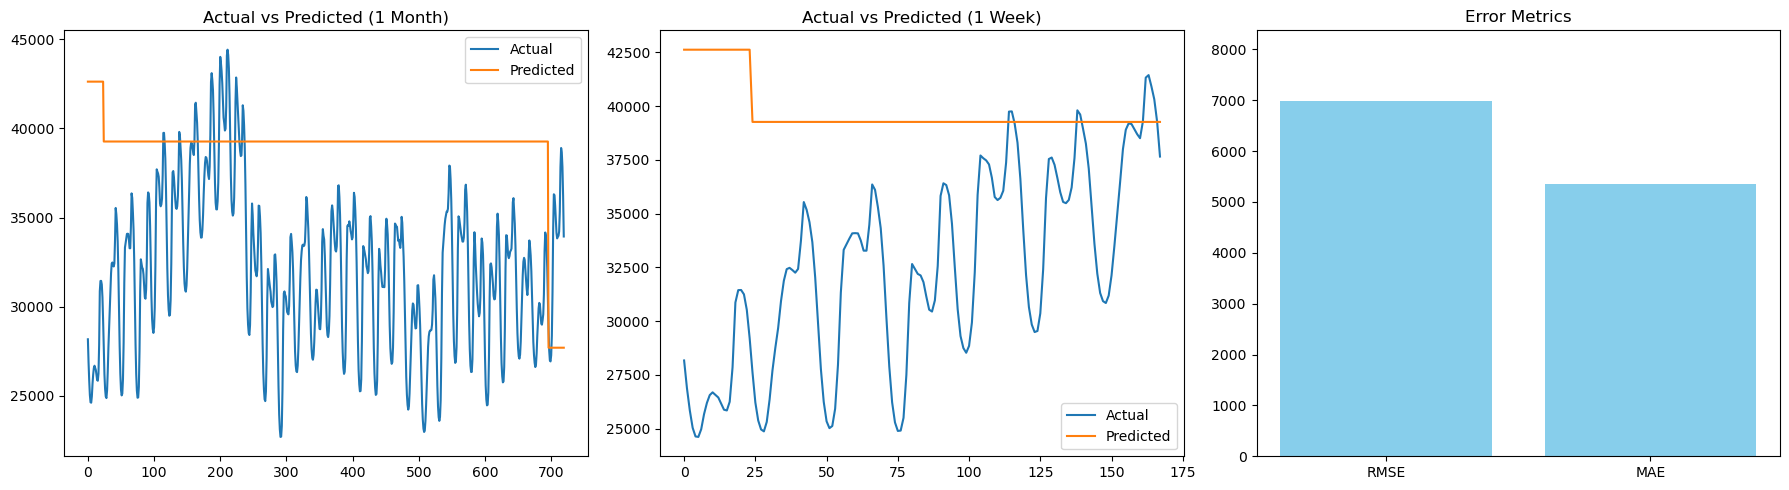

Plots Logged...
Model Logged...
Params Logged...
RandomForestfitted


/Users/marek/miniconda3/envs/python-for-data-analysis/lib/python3.13/site-packages/mlflow/models/__init__.py:37: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  self.utc_time_created = str(utc_time_created or datetime.utcnow())


6094.718010701189
4627.491940126655
Metric Logged...


<Figure size 640x480 with 0 Axes>

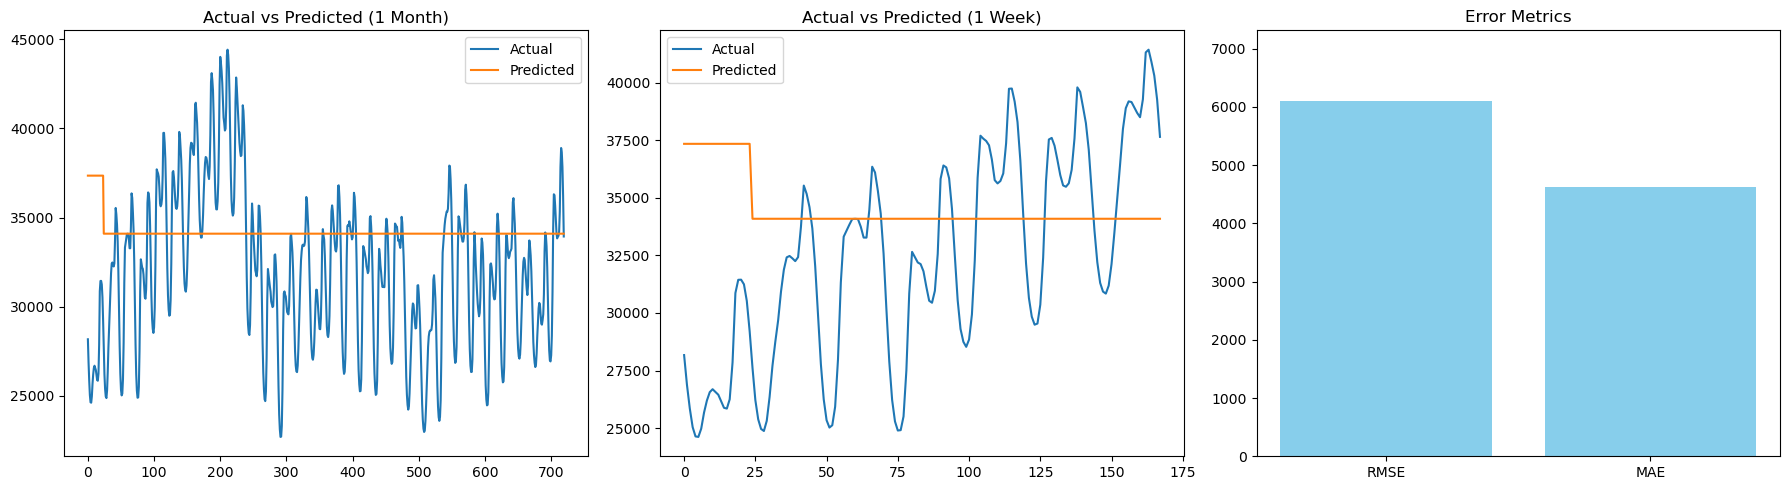

Plots Logged...
Model Logged...
Params Logged...
RandomForestfitted


/Users/marek/miniconda3/envs/python-for-data-analysis/lib/python3.13/site-packages/mlflow/models/__init__.py:37: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  self.utc_time_created = str(utc_time_created or datetime.utcnow())


7005.925712157448
5249.85384283247
Metric Logged...


<Figure size 640x480 with 0 Axes>

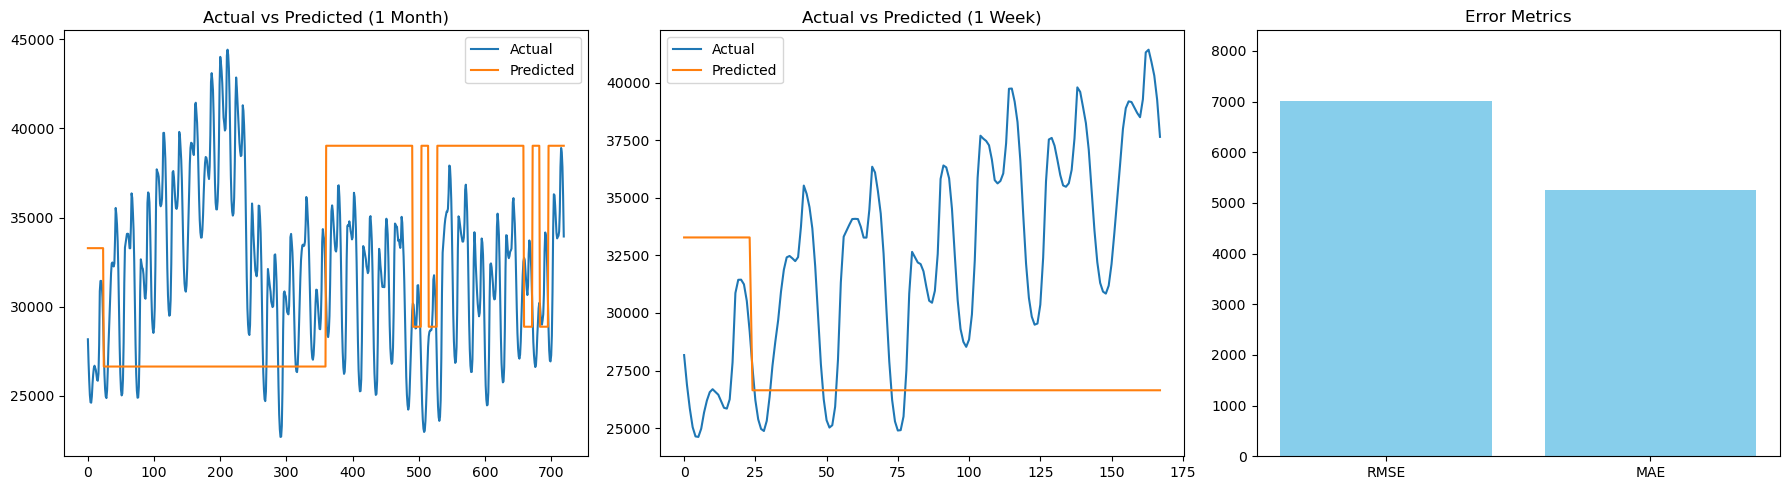

Plots Logged...
Model Logged...
Params Logged...
XGBoostfitted
4711.777821309413
3409.7751817631874
Metric Logged...


/Users/marek/miniconda3/envs/python-for-data-analysis/lib/python3.13/site-packages/mlflow/models/__init__.py:37: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  self.utc_time_created = str(utc_time_created or datetime.utcnow())


<Figure size 640x480 with 0 Axes>

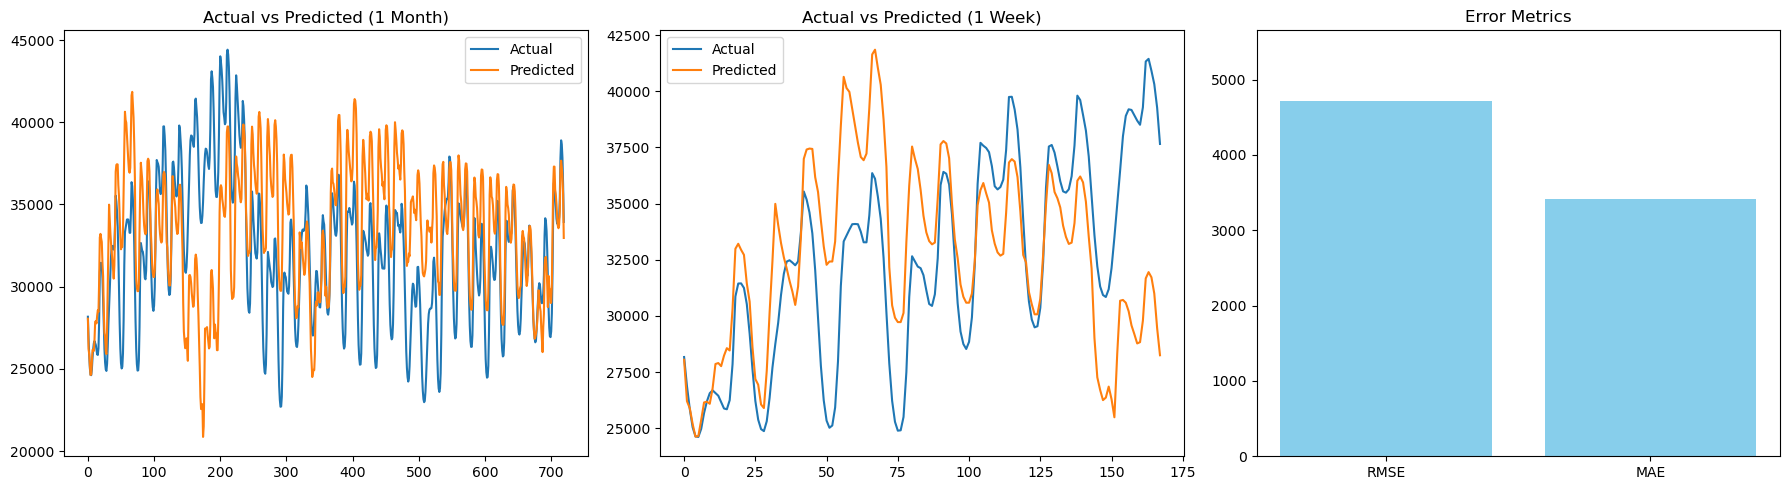

Plots Logged...
Model Logged...
Params Logged...
XGBoostfitted


/Users/marek/miniconda3/envs/python-for-data-analysis/lib/python3.13/site-packages/mlflow/models/__init__.py:37: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  self.utc_time_created = str(utc_time_created or datetime.utcnow())


4654.118955100515
3396.4560157543087
Metric Logged...


<Figure size 640x480 with 0 Axes>

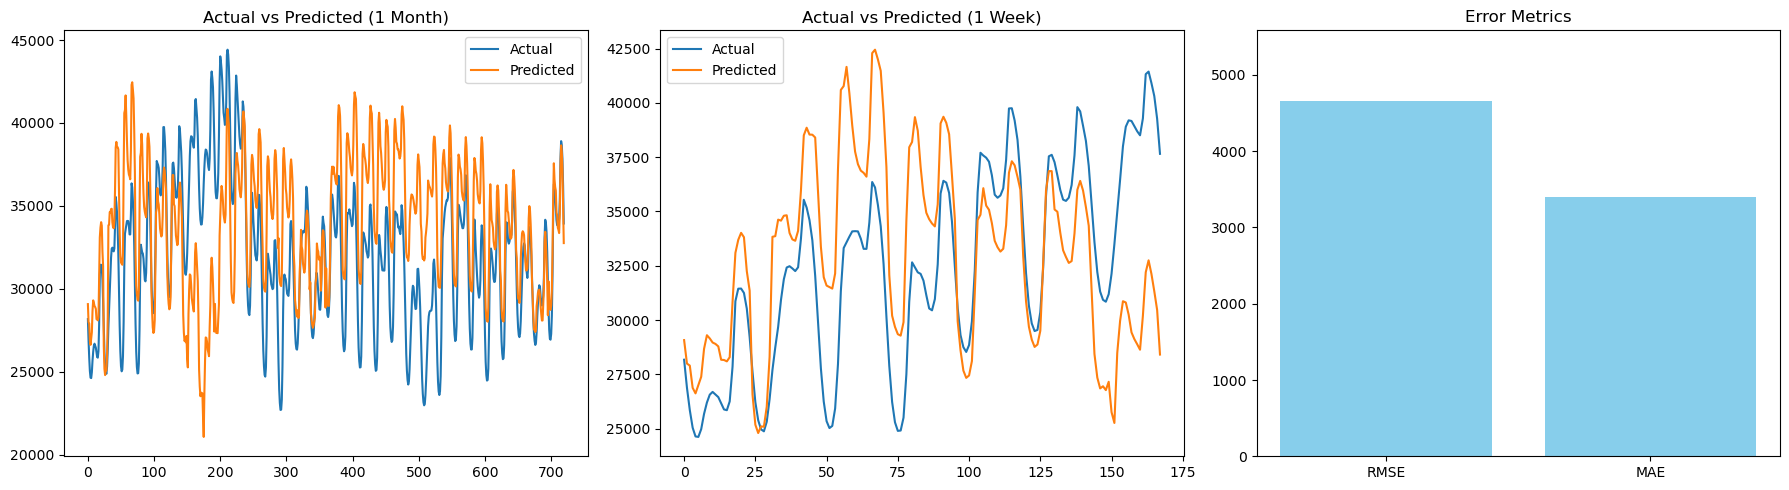

Plots Logged...
Model Logged...
Params Logged...
XGBoostfitted


/Users/marek/miniconda3/envs/python-for-data-analysis/lib/python3.13/site-packages/mlflow/models/__init__.py:37: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  self.utc_time_created = str(utc_time_created or datetime.utcnow())


4634.556008599346
3382.4372173478428
Metric Logged...


<Figure size 640x480 with 0 Axes>

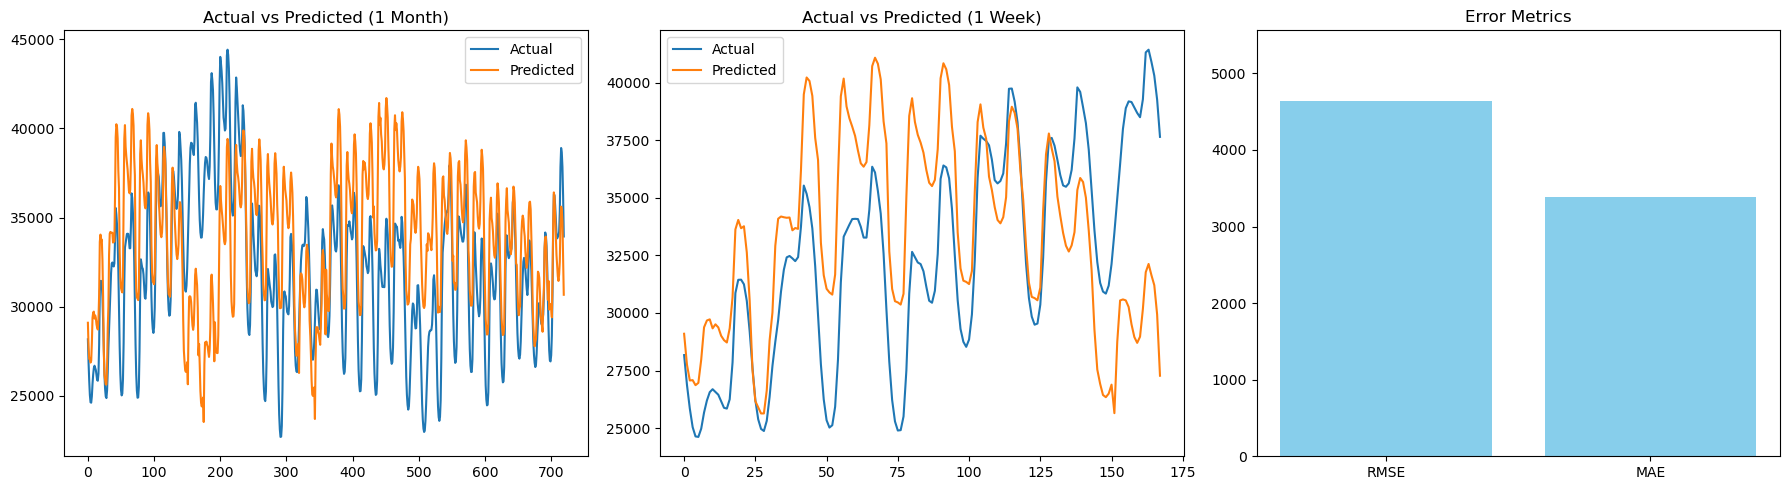

Plots Logged...
Model Logged...
Params Logged...
LinearRegressionfitted
1153.238347300225
909.4683652709213
Metric Logged...


/Users/marek/miniconda3/envs/python-for-data-analysis/lib/python3.13/site-packages/mlflow/models/__init__.py:37: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  self.utc_time_created = str(utc_time_created or datetime.utcnow())


<Figure size 640x480 with 0 Axes>

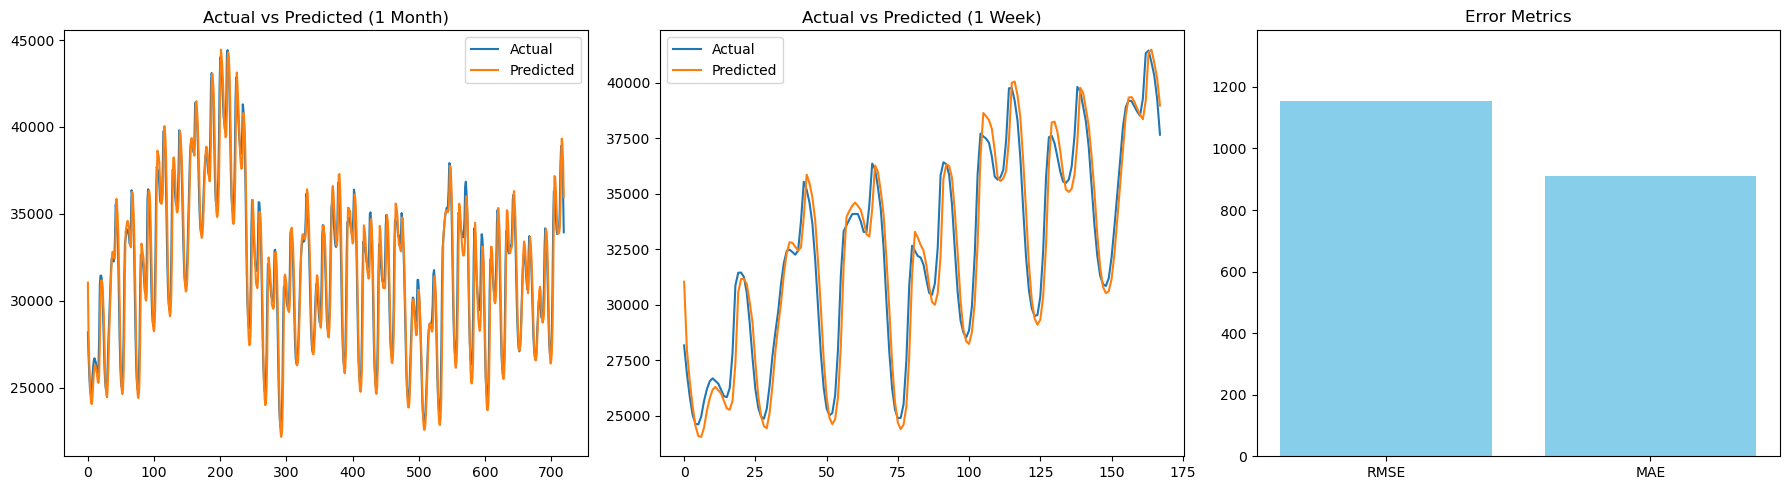

Plots Logged...
Model Logged...
Params Logged...
LinearRegressionfitted
1121.807345919641
880.8779946915876
Metric Logged...


/Users/marek/miniconda3/envs/python-for-data-analysis/lib/python3.13/site-packages/mlflow/models/__init__.py:37: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  self.utc_time_created = str(utc_time_created or datetime.utcnow())


<Figure size 640x480 with 0 Axes>

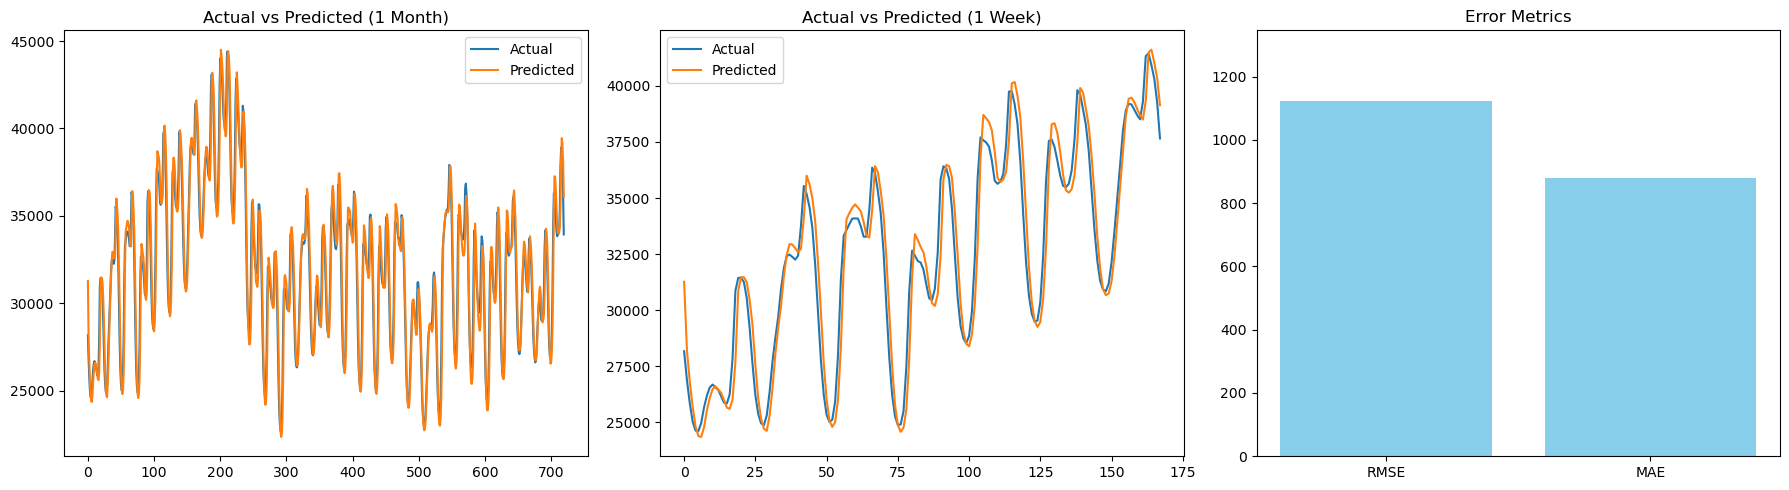

Plots Logged...
Model Logged...
Params Logged...
LinearRegressionfitted
1116.012052385824
875.5299217913547
Metric Logged...


/Users/marek/miniconda3/envs/python-for-data-analysis/lib/python3.13/site-packages/mlflow/models/__init__.py:37: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  self.utc_time_created = str(utc_time_created or datetime.utcnow())


<Figure size 640x480 with 0 Axes>

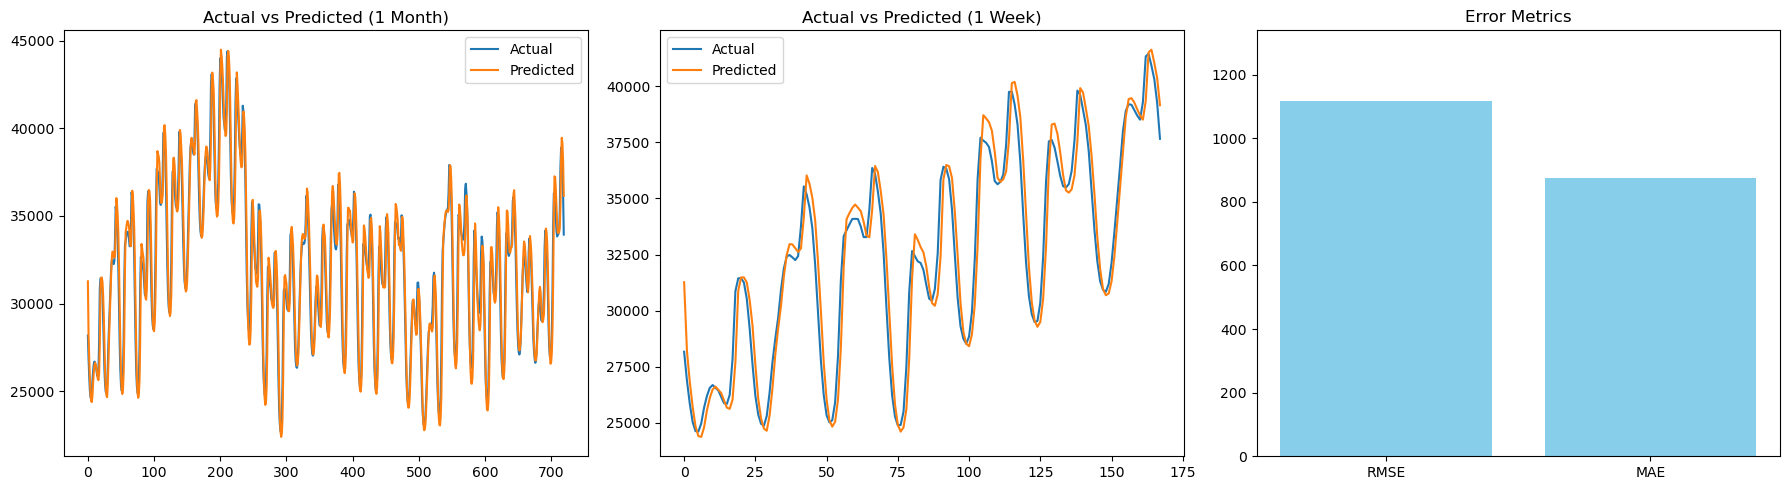

Plots Logged...
Model Logged...
Params Logged...


/Users/marek/miniconda3/envs/python-for-data-analysis/lib/python3.13/site-packages/mlflow/models/__init__.py:37: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  self.utc_time_created = str(utc_time_created or datetime.utcnow())


RandomForestfitted
4675.604618665521
3475.276050662061
Metric Logged...


<Figure size 640x480 with 0 Axes>

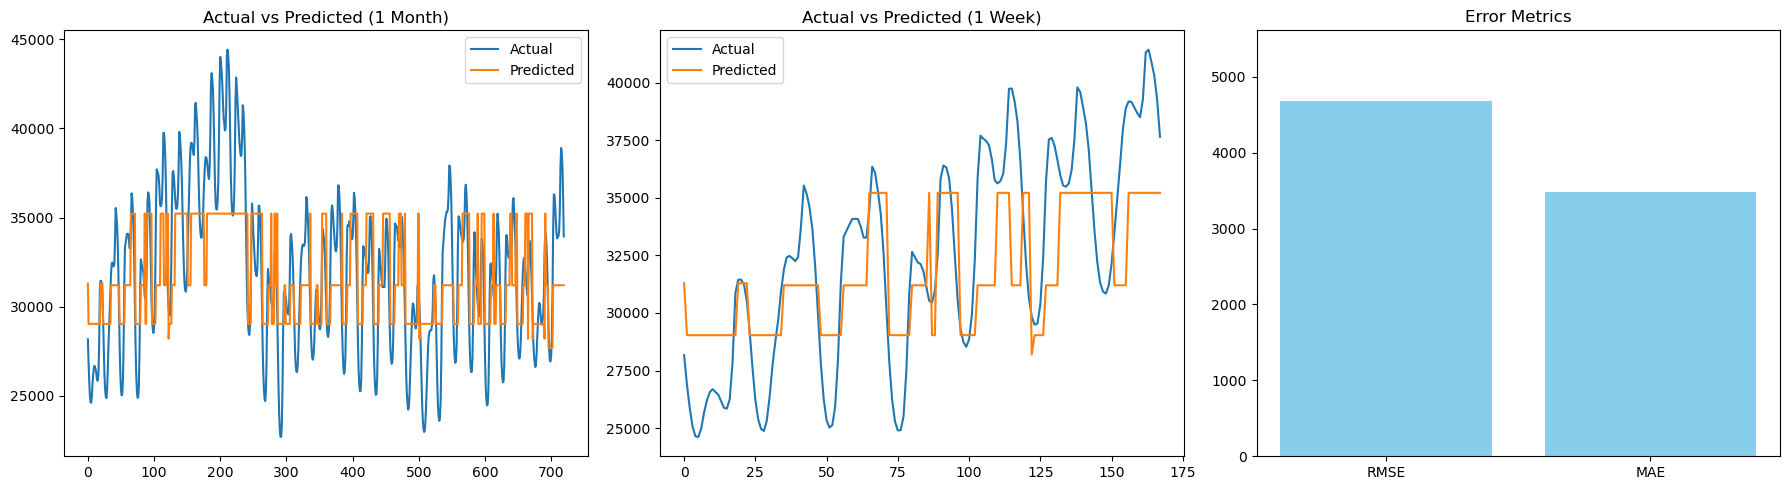

Plots Logged...
Model Logged...
Params Logged...


/Users/marek/miniconda3/envs/python-for-data-analysis/lib/python3.13/site-packages/mlflow/models/__init__.py:37: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  self.utc_time_created = str(utc_time_created or datetime.utcnow())


RandomForestfitted
4785.69330495703
3574.061528497409
Metric Logged...


<Figure size 640x480 with 0 Axes>

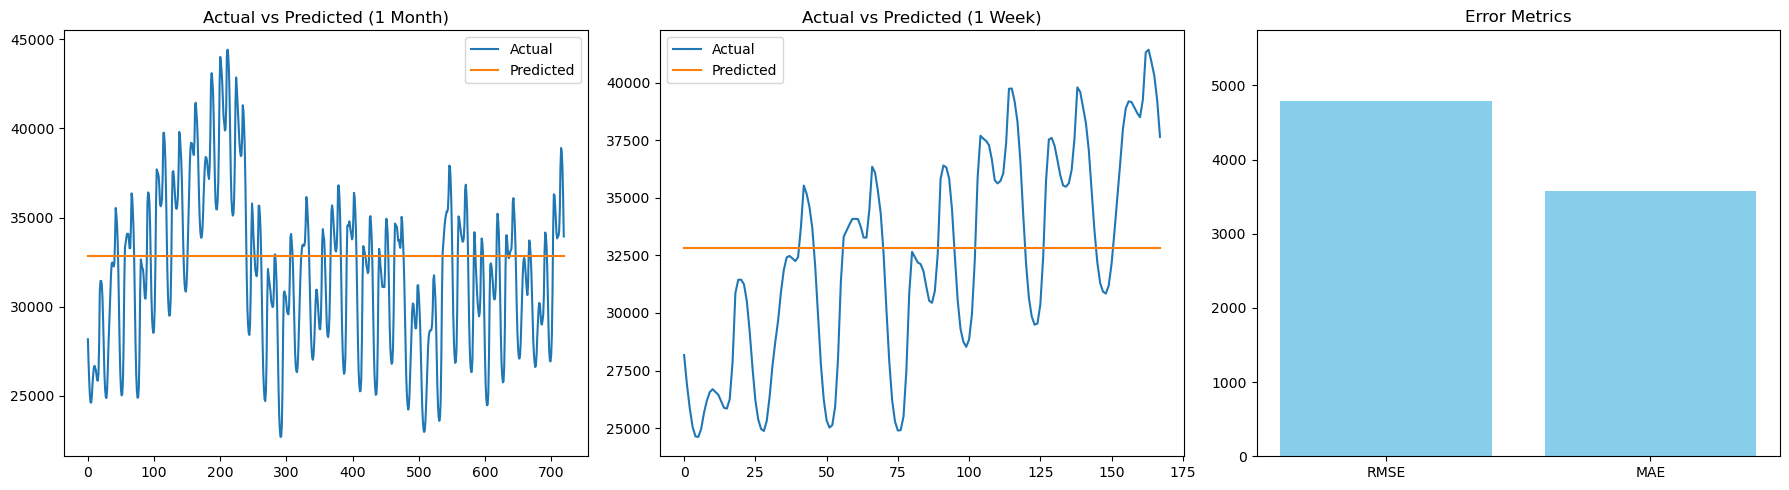

Plots Logged...
Model Logged...
Params Logged...


/Users/marek/miniconda3/envs/python-for-data-analysis/lib/python3.13/site-packages/mlflow/models/__init__.py:37: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  self.utc_time_created = str(utc_time_created or datetime.utcnow())


RandomForestfitted
4046.749879880613
2716.578080023028
Metric Logged...


<Figure size 640x480 with 0 Axes>

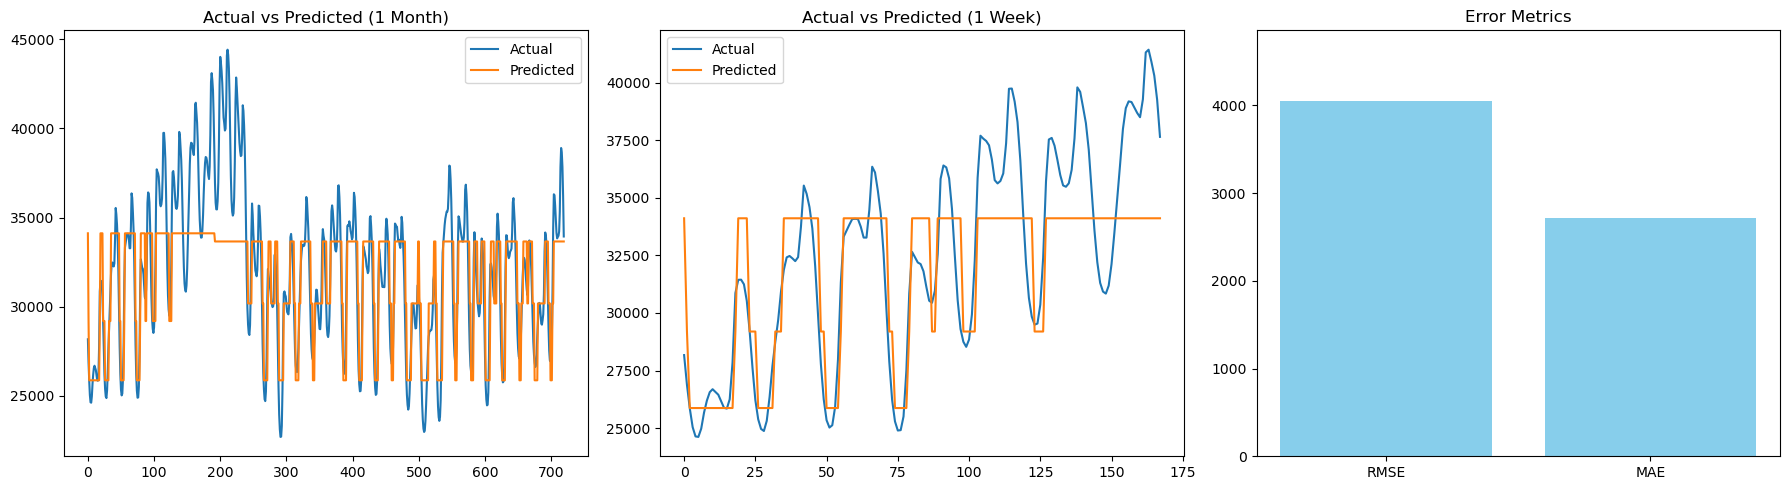

Plots Logged...
Model Logged...
Params Logged...


/Users/marek/miniconda3/envs/python-for-data-analysis/lib/python3.13/site-packages/mlflow/models/__init__.py:37: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  self.utc_time_created = str(utc_time_created or datetime.utcnow())


XGBoostfitted
433.7110704741171
314.9627689060701
Metric Logged...


<Figure size 640x480 with 0 Axes>

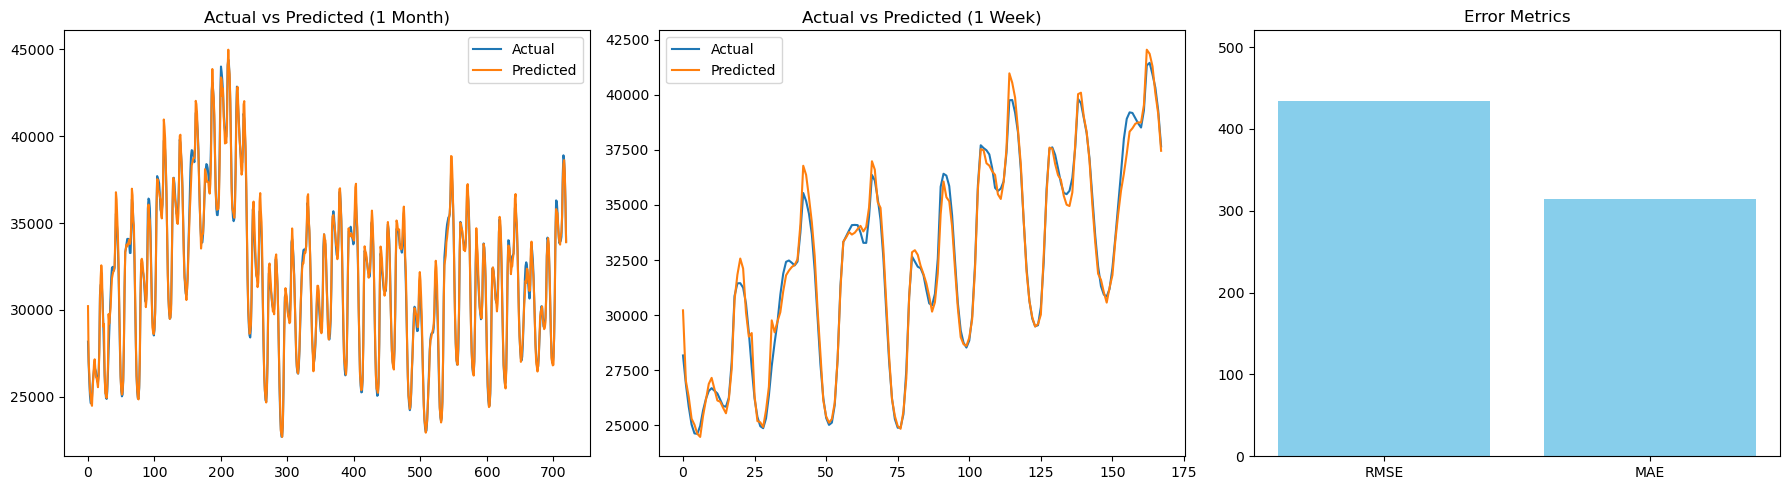

Plots Logged...
Model Logged...
Params Logged...


/Users/marek/miniconda3/envs/python-for-data-analysis/lib/python3.13/site-packages/mlflow/models/__init__.py:37: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  self.utc_time_created = str(utc_time_created or datetime.utcnow())


XGBoostfitted
402.048210206859
295.225933103501
Metric Logged...


<Figure size 640x480 with 0 Axes>

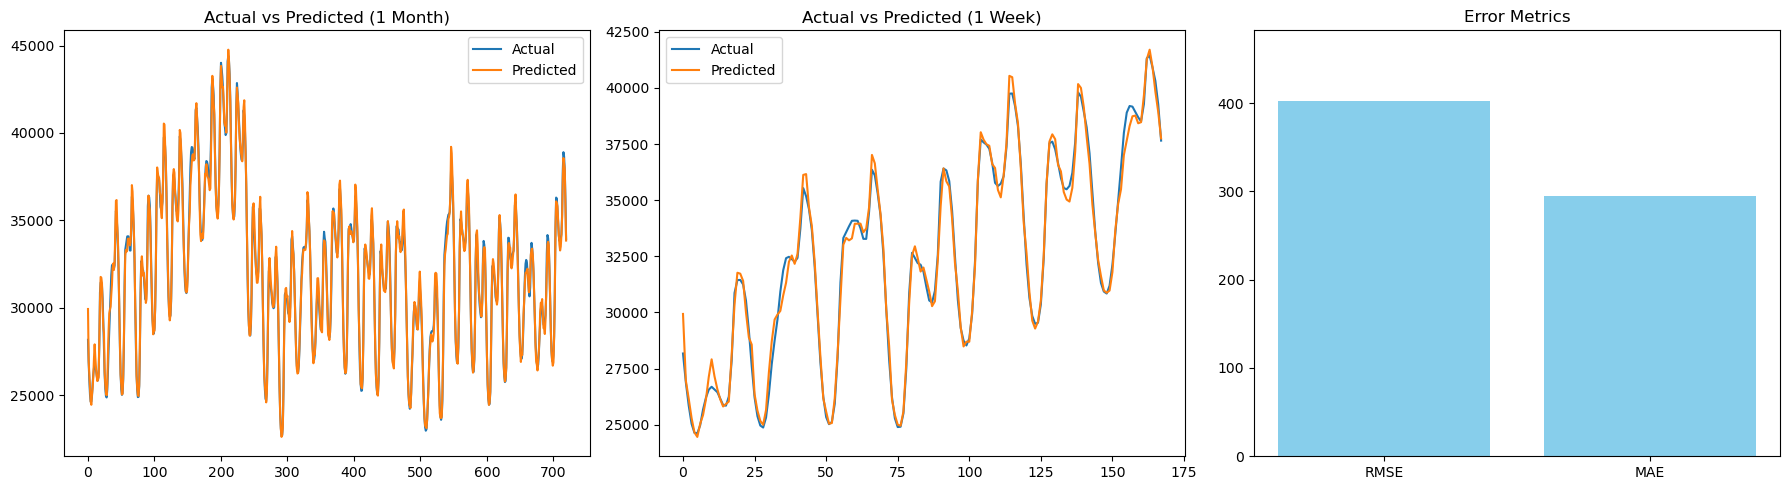

Plots Logged...
Model Logged...
Params Logged...


/Users/marek/miniconda3/envs/python-for-data-analysis/lib/python3.13/site-packages/mlflow/models/__init__.py:37: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  self.utc_time_created = str(utc_time_created or datetime.utcnow())


XGBoostfitted
391.0637480343911
286.2720333751619
Metric Logged...


<Figure size 640x480 with 0 Axes>

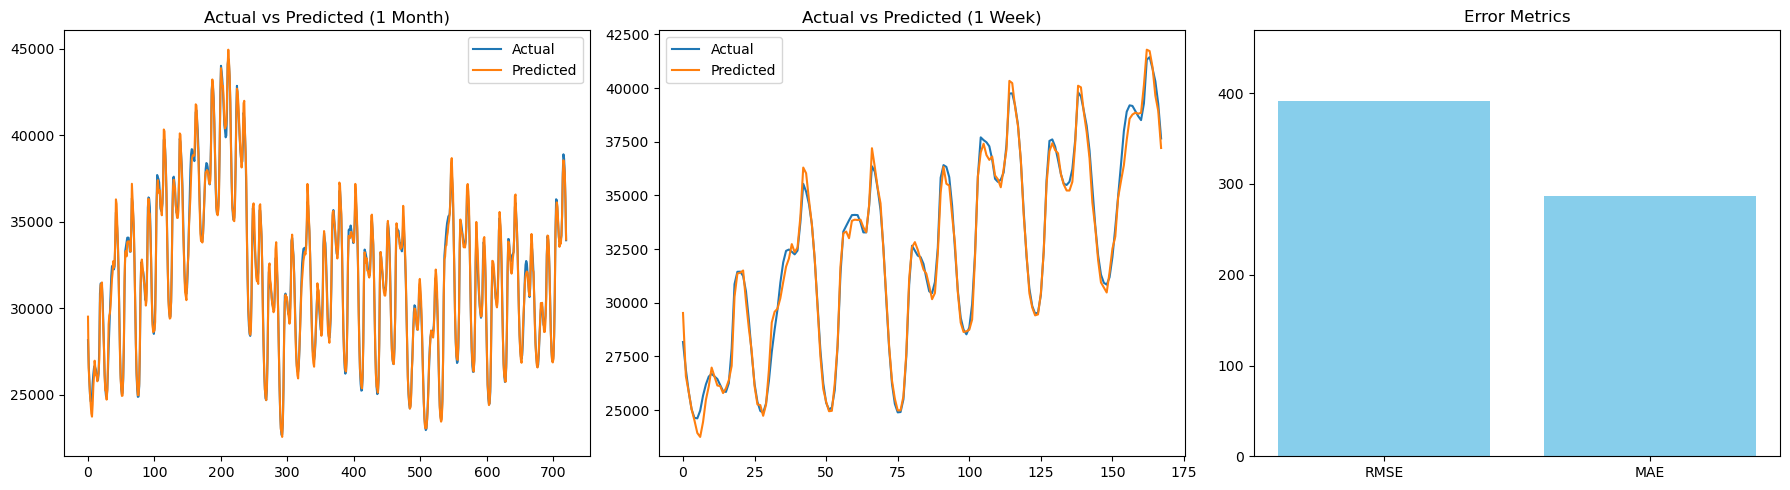

Plots Logged...
Model Logged...
Params Logged...
LinearRegressionfitted
784.8389816885046
613.9844106433063
Metric Logged...


/Users/marek/miniconda3/envs/python-for-data-analysis/lib/python3.13/site-packages/mlflow/models/__init__.py:37: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  self.utc_time_created = str(utc_time_created or datetime.utcnow())


<Figure size 640x480 with 0 Axes>

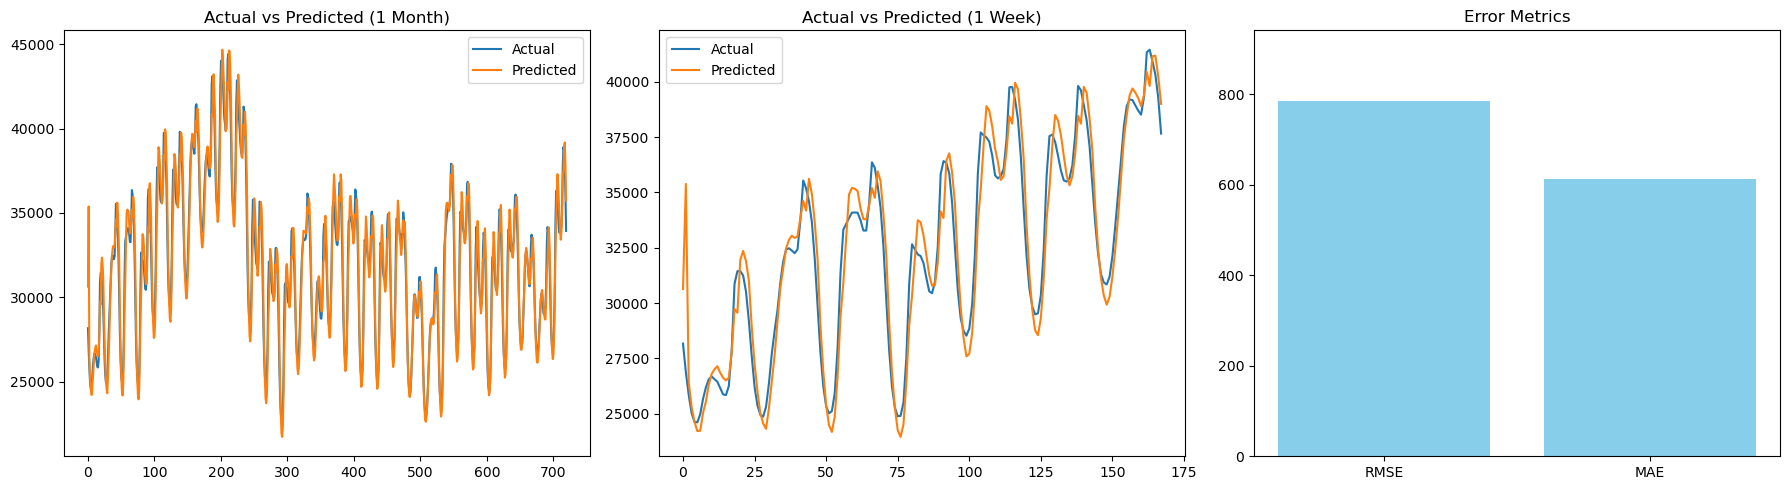

Plots Logged...
Model Logged...
Params Logged...
LinearRegressionfitted
784.2441407893394
611.8423408694722
Metric Logged...


/Users/marek/miniconda3/envs/python-for-data-analysis/lib/python3.13/site-packages/mlflow/models/__init__.py:37: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  self.utc_time_created = str(utc_time_created or datetime.utcnow())


<Figure size 640x480 with 0 Axes>

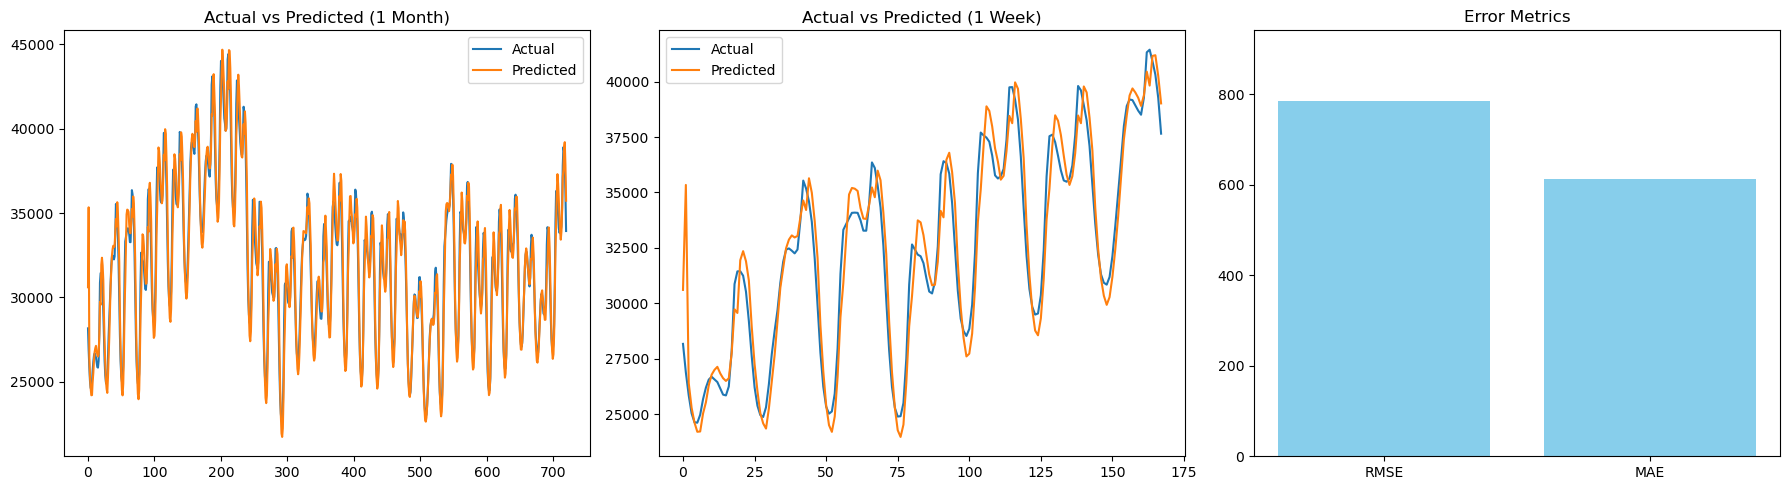

Plots Logged...
Model Logged...
Params Logged...
LinearRegressionfitted
784.1613952485469
610.3344365206526
Metric Logged...


/Users/marek/miniconda3/envs/python-for-data-analysis/lib/python3.13/site-packages/mlflow/models/__init__.py:37: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  self.utc_time_created = str(utc_time_created or datetime.utcnow())


<Figure size 640x480 with 0 Axes>

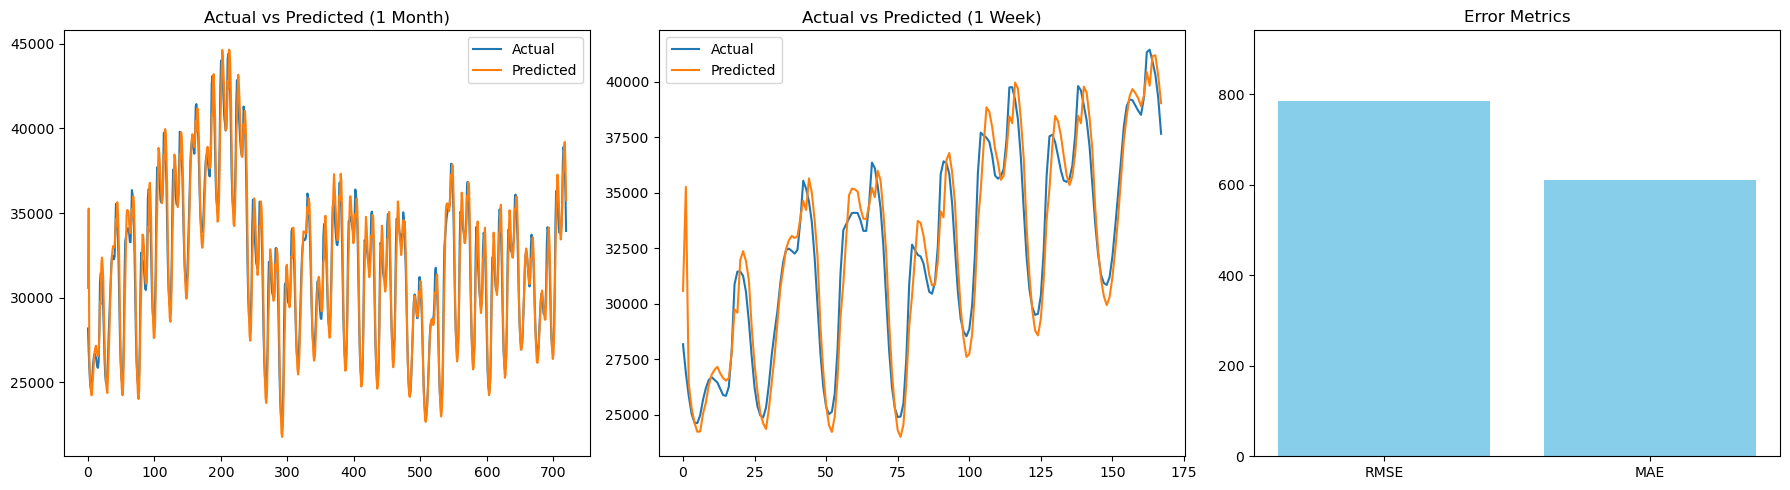

Plots Logged...
Model Logged...
Params Logged...


/Users/marek/miniconda3/envs/python-for-data-analysis/lib/python3.13/site-packages/mlflow/models/__init__.py:37: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  self.utc_time_created = str(utc_time_created or datetime.utcnow())


RandomForestfitted
4963.547353523556
3749.30059009787
Metric Logged...


<Figure size 640x480 with 0 Axes>

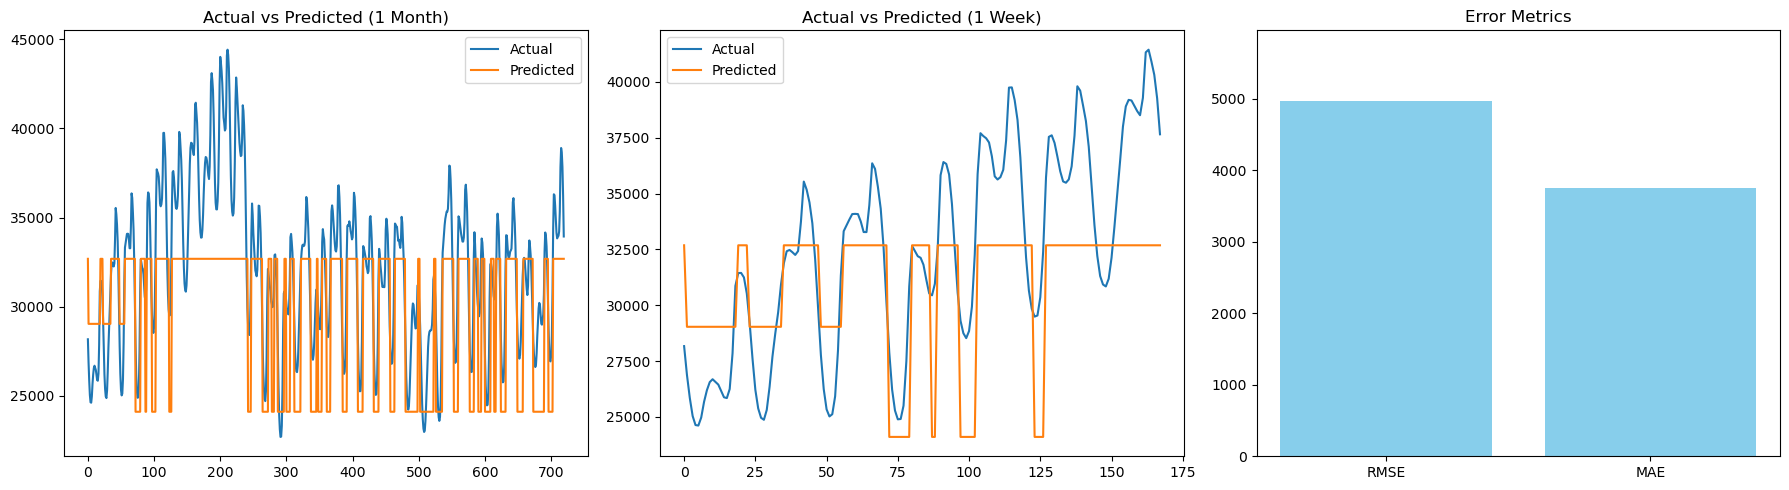

Plots Logged...
Model Logged...
Params Logged...


/Users/marek/miniconda3/envs/python-for-data-analysis/lib/python3.13/site-packages/mlflow/models/__init__.py:37: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  self.utc_time_created = str(utc_time_created or datetime.utcnow())


RandomForestfitted
5203.253581217698
3785.725100748417
Metric Logged...


<Figure size 640x480 with 0 Axes>

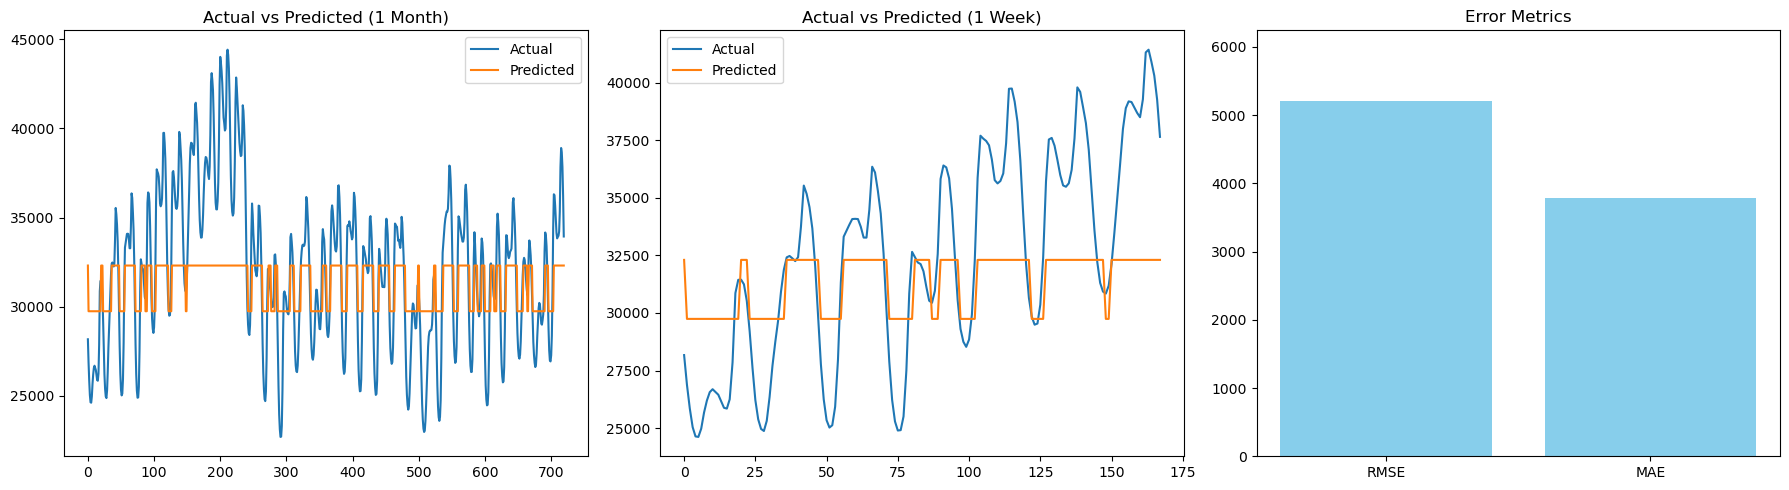

Plots Logged...
Model Logged...
Params Logged...


/Users/marek/miniconda3/envs/python-for-data-analysis/lib/python3.13/site-packages/mlflow/models/__init__.py:37: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  self.utc_time_created = str(utc_time_created or datetime.utcnow())


RandomForestfitted
2698.139537056553
1984.6721358664363
Metric Logged...


<Figure size 640x480 with 0 Axes>

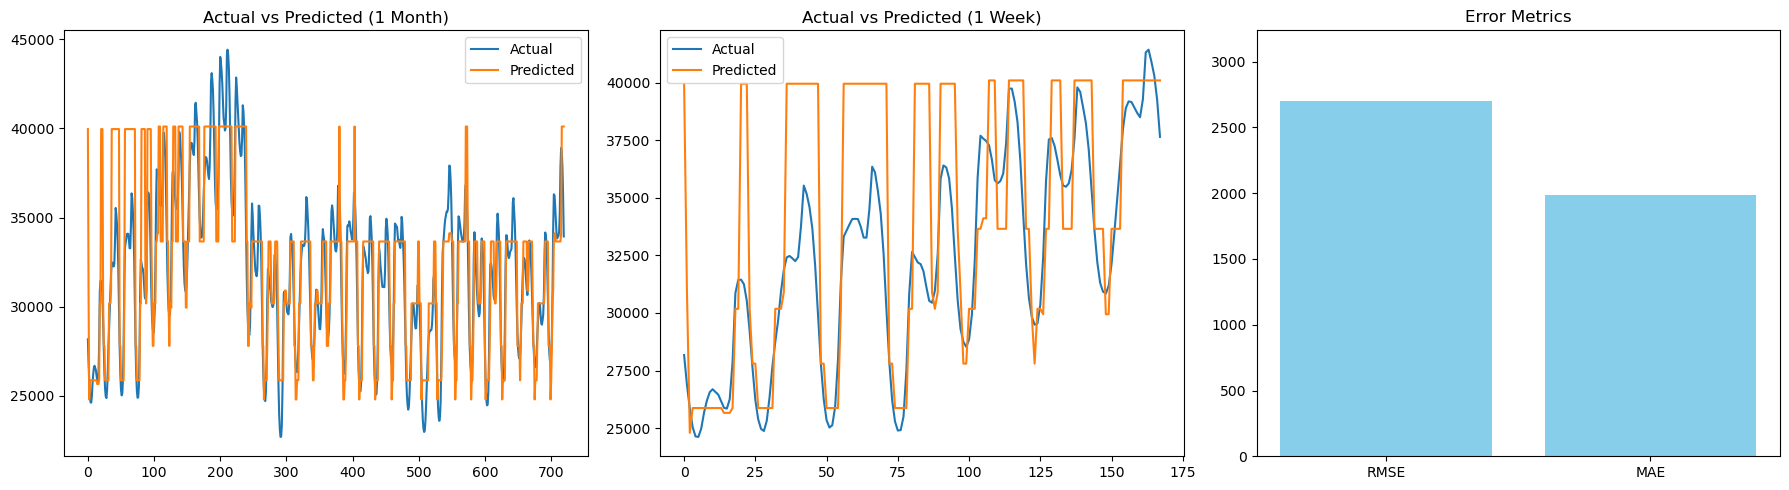

Plots Logged...
Model Logged...
Params Logged...


/Users/marek/miniconda3/envs/python-for-data-analysis/lib/python3.13/site-packages/mlflow/models/__init__.py:37: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  self.utc_time_created = str(utc_time_created or datetime.utcnow())


XGBoostfitted
397.6300258300387
293.80099770167675
Metric Logged...


<Figure size 640x480 with 0 Axes>

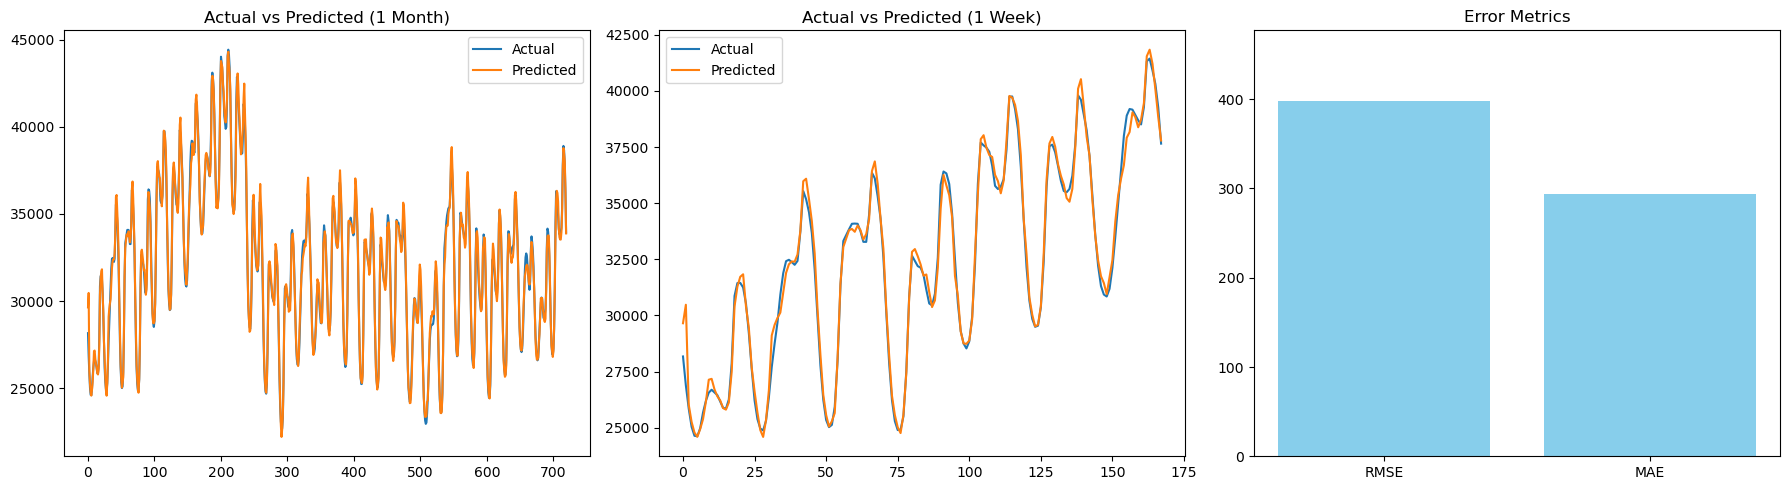

Plots Logged...
Model Logged...
Params Logged...


/Users/marek/miniconda3/envs/python-for-data-analysis/lib/python3.13/site-packages/mlflow/models/__init__.py:37: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  self.utc_time_created = str(utc_time_created or datetime.utcnow())


XGBoostfitted
383.40239519609474
279.3552036669725
Metric Logged...


<Figure size 640x480 with 0 Axes>

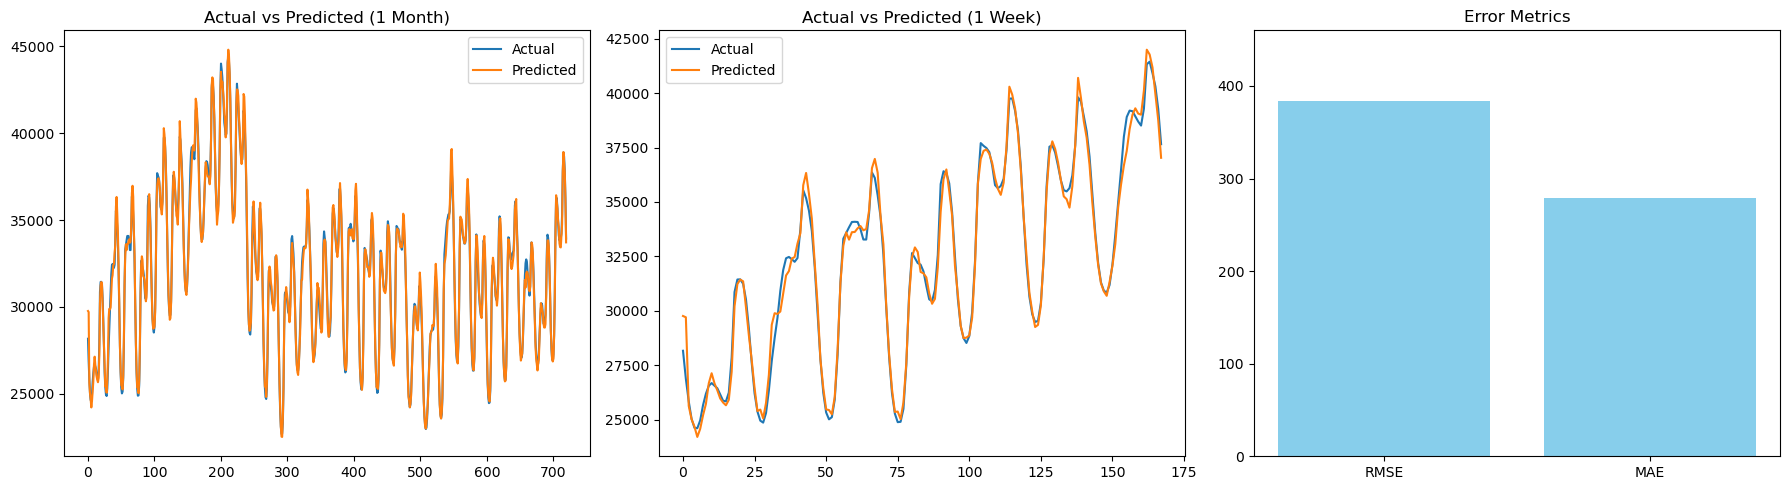

Plots Logged...
Model Logged...
Params Logged...


/Users/marek/miniconda3/envs/python-for-data-analysis/lib/python3.13/site-packages/mlflow/models/__init__.py:37: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  self.utc_time_created = str(utc_time_created or datetime.utcnow())


XGBoostfitted
383.969793229123
282.6690770106955
Metric Logged...


<Figure size 640x480 with 0 Axes>

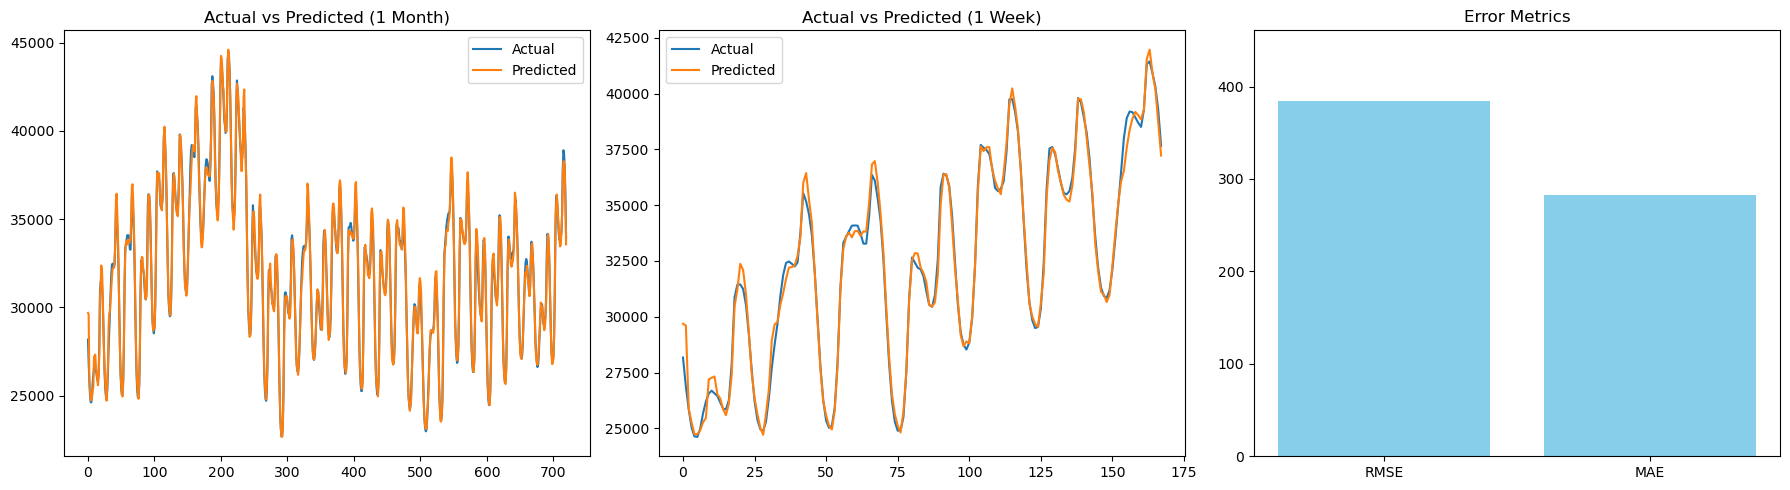

Plots Logged...
Model Logged...

Summary of Experiment Results:
                                             features             model  \
0   [hour, dayofweek, quarter, month, year, dayofy...  LinearRegression   
1   [hour, dayofweek, quarter, month, year, dayofy...  LinearRegression   
2   [hour, dayofweek, quarter, month, year, dayofy...  LinearRegression   
3   [hour, dayofweek, quarter, month, year, dayofy...      RandomForest   
4   [hour, dayofweek, quarter, month, year, dayofy...      RandomForest   
5   [hour, dayofweek, quarter, month, year, dayofy...      RandomForest   
6   [hour, dayofweek, quarter, month, year, dayofy...           XGBoost   
7   [hour, dayofweek, quarter, month, year, dayofy...           XGBoost   
8   [hour, dayofweek, quarter, month, year, dayofy...           XGBoost   
9   [hour, dayofweek, quarter, month, year, dayofy...  LinearRegression   
10  [hour, dayofweek, quarter, month, year, dayofy...  LinearRegression   
11  [hour, dayofweek, quarter, month

/Users/marek/miniconda3/envs/python-for-data-analysis/lib/python3.13/site-packages/mlflow/models/__init__.py:37: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  self.utc_time_created = str(utc_time_created or datetime.utcnow())


<Figure size 640x480 with 0 Axes>

In [6]:
mlflow.set_experiment('MLFlow Exercise 1')

results = []

for features in feature_combinations:
    for model_name, model in models:
        for train_name, train, test in train_test_combinations:                    
            with mlflow.start_run():

                mlflow.log_param('features', features)
                mlflow.log_param('model_type', model_name)
                mlflow.log_param('train_name', train_name)

                print('Params Logged...')

                model.fit(train[features], train[TARGET])

                print(model_name + 'fitted')
                predictions = model.predict(test[features])

                RMSE = root_mean_squared_error(test[TARGET],predictions)
                print(RMSE)
                MAE = mean_absolute_error(test[TARGET],predictions)
                print(MAE)


                mlflow.log_metric('RMSE', RMSE)
                mlflow.log_metric('MAE', MAE)
                print('Metric Logged...')

                fig, axs = plt.subplots(1, 3, figsize=(18, 5))

                axs[0].plot(test[TARGET].values[:720], label='Actual')
                axs[0].plot(predictions[:720], label='Predicted')
                axs[0].set_title('Actual vs Predicted (1 Month)')
                axs[0].legend()

                axs[1].plot(test[TARGET].values[:168], label='Actual')
                axs[1].plot(predictions[:168], label='Predicted')
                axs[1].set_title('Actual vs Predicted (1 Week)')
                axs[1].legend()

                axs[2].bar(['RMSE', 'MAE'], [RMSE, MAE], color='skyblue')
                axs[2].set_title('Error Metrics')
                axs[2].set_ylim(0, max(RMSE, MAE) * 1.2)

                plt.tight_layout()
                plt.show()

                temp_file = tempfile.NamedTemporaryFile(suffix=".png", delete=False)
                plt.savefig(temp_file.name)
                mlflow.log_artifact(temp_file.name, artifact_path="plots")
                temp_file.close()

                print('Plots Logged...')


                mlflow.sklearn.log_model(model, model_name)

                print('Model Logged...')

                results.append({
                'features': features,
                'model': model_name,
                'test': train_name,
                'RMSE': RMSE,
                'MAE': MAE,
            })


results_df = pd.DataFrame(results)
print("\nSummary of Experiment Results:")
print(results_df)


In [7]:

print("\nStarting MLFlow UI...")
process = subprocess.Popen(["mlflow", "ui", "--port", "5000"])

time.sleep(3)

print("MLFlow UI is running at http://localhost:5000. Press Ctrl+C in the terminal to stop it.")


Starting MLFlow UI...


/Users/marek/miniconda3/envs/python-for-data-analysis/lib/python3.13/site-packages/mlflow/models/__init__.py:37: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  self.utc_time_created = str(utc_time_created or datetime.utcnow())
/Users/marek/miniconda3/envs/python-for-data-analysis/lib/python3.13/site-packages/mlflow/models/container/__init__.py:16: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import resource_filename
/Users/marek/miniconda3/envs/python-for-data-analysis/lib/python3.13/site-packages/pkg_resources/__init__.py:3144: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https:

MLFlow UI is running at http://localhost:5000. Press Ctrl+C in the terminal to stop it.
